# Classweight balancing

In [2]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

import matplotlib.image as mpimg

import sklearn.metrics as metrics

import tensorflow
import tensorflow as tf



from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image


###### Tensorflow-GPU ########
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:  # Check if the list is not empty
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU devices found.")

import re

#K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

No GPU devices found.


## Bank

A bank tries to predict whether a client will sign a certain insurance contract. The file 'bank.csv' contains data of thousands of clients.
The features include:
Input variables:

1 - age (numeric)

2 - job : type of job (categorical:admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric) 

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")


The output variable = y. yes meaning the client signed the contract, no meaning the client didn't sign the contract.


Your task is to train a conventional feedforward neural network to predict the target y. Use a test set of 10000 samples. 

In [3]:
# Import customer satisfaction datataset

dataset = pd.read_csv('bank.csv',delimiter=';')
dataset.tail()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [4]:
# Statistical description of the dataset:

dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
# in practise the duration column is not available. That's why it needs to be removed from the dataset

# remove the 'duration' column

dataset.drop('duration',axis=1, inplace=True)


In [6]:
# For all features with a yes/no answers change to numerical values: yes -> 1 and no -> 0

dataset.replace(["no","yes"], [0, 1], inplace=True)

/var/folders/0r/s3s7wy7x0z33qbtj01kxq24w0000gn/T/ipykernel_34211/2114779205.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.replace(["no","yes"], [0, 1], inplace=True)


In [7]:
# Apply one-hot encoding to the remaining categorical features. 

# Example: 
# one-hot encoding of job
dataset = pd.concat([dataset,pd.get_dummies(dataset['job'], prefix='job')],axis=1)
dataset.drop(['job'],axis=1, inplace=True)

# one-hot encoding of marital
dataset = pd.concat([dataset,pd.get_dummies(dataset['marital'], prefix='marital')],axis=1)
dataset.drop(['marital'],axis=1, inplace=True)

# one-hot encoding of education
dataset = pd.concat([dataset,pd.get_dummies(dataset['education'], prefix='education')],axis=1)
dataset.drop(['education'],axis=1, inplace=True)

# one-hot encoding of contact
dataset = pd.concat([dataset,pd.get_dummies(dataset['contact'], prefix='contact')],axis=1)
dataset.drop(['contact'],axis=1, inplace=True)

# one-hot encoding of month
dataset = pd.concat([dataset,pd.get_dummies(dataset['month'], prefix='month')],axis=1)
dataset.drop(['month'],axis=1, inplace=True)

# one-hot encoding of poutcome
dataset = pd.concat([dataset,pd.get_dummies(dataset['poutcome'], prefix='poutcome')],axis=1)
dataset.drop(['poutcome'],axis=1, inplace=True)

In [8]:
# Split dataset into features and targets

y = dataset.y.values
X = dataset.drop('y',axis=1)

print(X.shape)
print(y.shape)

(45211, 47)
(45211,)


In [9]:
# Split into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state =0)

# One-hot encoding of the targets
y_train_orig= y_train  # keep the original labels for testing purposes
#y_train = to_categorical(y_train)


In [10]:
# Normalization of the features: Try Min-Max, standardscaler or robust scaler

# Standardscaler
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# MinMax scaler

scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = np.asarray(scaler.transform(X_train)).astype('float32')
X_test = np.asarray(scaler.transform(X_test)).astype('float32')


In [11]:
# Train a Neural network on the training data. Use 20 percent of the training data as validation data.

# Initialize the neural network

## parameters of the NN
model = Sequential()
dropoutrate = 0.2
batchsize = 128
inputdim = X_train.shape[1]  #30 input features
adam = tf.keras.optimizers.Adam() # Adam optimizer

model.add(Dense(40, input_dim=inputdim, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(40, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(10, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=adam,metrics=['accuracy'])

# Training

history = model.fit(X_train, y_train, epochs=50,validation_split=0.2, batch_size=batchsize,verbose=1)






Epoch 1/50


/Users/pascal-maker/pascalworkspace/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5297 - loss: 0.7637 - val_accuracy: 0.8831 - val_loss: 0.4479
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.8819 - loss: 0.3938 - val_accuracy: 0.8914 - val_loss: 0.3292
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.8945 - loss: 0.3356 - val_accuracy: 0.8900 - val_loss: 0.3163
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.8897 - loss: 0.3258 - val_accuracy: 0.8907 - val_loss: 0.3082
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.8963 - loss: 0.3135 - val_accuracy: 0.8910 - val_loss: 0.3045
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.8931 - loss: 0.3128 - val_accuracy: 0.8912 - val_loss: 0.3046
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.8924 - loss: 0.3075 - val_accuracy: 0.8900 - val_loss: 0.3029
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.8936 - loss: 0.3071 - val_accuracy:

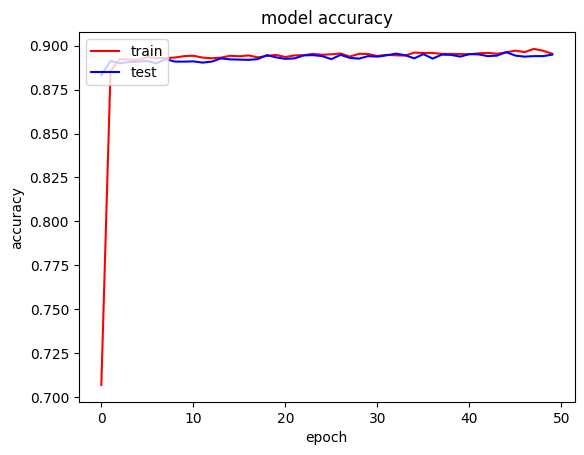

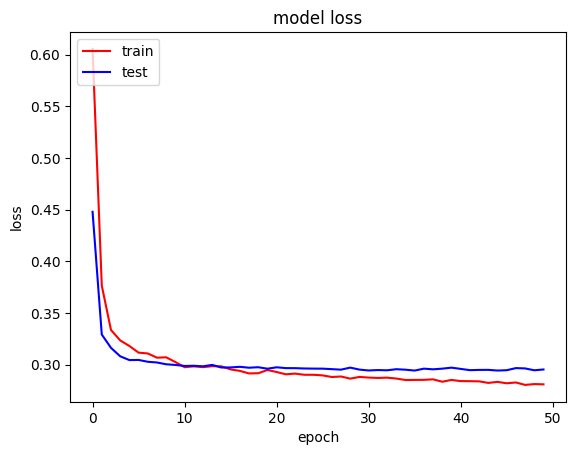

In [12]:
# Plot of the training history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


              precision    recall  f1-score   support

           0       0.91      0.98      0.94      8824
           1       0.61      0.25      0.36      1176

    accuracy                           0.89     10000
   macro avg       0.76      0.62      0.65     10000
weighted avg       0.87      0.89      0.87     10000

[[8635  189]
 [ 879  297]]
89.32
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


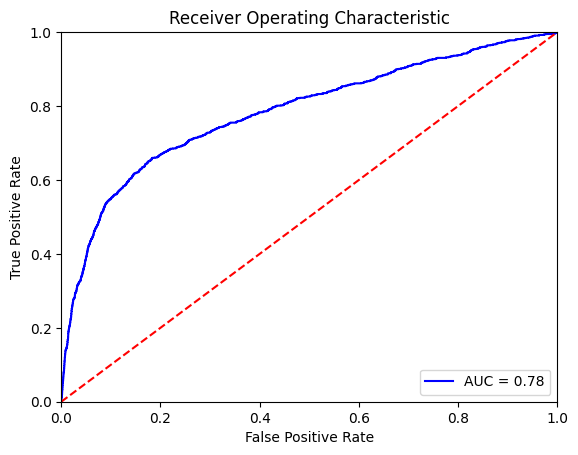

In [13]:
# Testing with the test set

y_pred = (model.predict(X_test) > 0.5).astype('int32')
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
preds = y_pred = model.predict(X_test) 
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Classweight balancing

As the data is unbalanced, the neural netwerk tends to have a preference for the majority class. 
One of the approaches is to use classweight balancing. This means that during the training phase, a misclassification of a sample from the minority class results in a higher loss.

count klasse 0:  39922
count klasse 1:  5289
ratio:  7.548118737001324


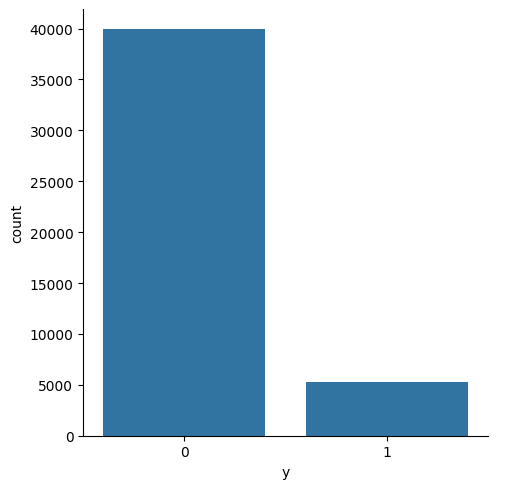

In [14]:
# Histogram of the classcount
label_count = np.bincount(y)

print('count klasse 0: ',label_count[0])
print('count klasse 1: ',label_count[1])

print('ratio: ',label_count[0]/label_count[1])


sns.catplot(x='y',kind='count', data=dataset)

In [15]:
# Train a Neural network on the training data. Use 20 percent of the training data as validation data.

# Initialize the neural network

## parameters of the NN
model = Sequential()
dropoutrate = 0.2
batchsize = 64
epochs = 10
inputdim = X_train.shape[1]  #30 input features
adam = tf.keras.optimizers.Adam() # Adam optimizer


model.add(Dense(40, input_dim=inputdim, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(40, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(10, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_orig),y=y_train_orig)
print(class_weights)
class_weights= dict(enumerate(class_weights))


history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=1,class_weight=class_weights)


[0.56612965 4.28045222]
Epoch 1/10


/Users/pascal-maker/pascalworkspace/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


881/881 ━━━━━━━━━━━━━━━━━━━━ 2s 829us/step - accuracy: 0.7246 - loss: 0.6596 - val_accuracy: 0.7977 - val_loss: 0.5220
Epoch 2/10
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.7374 - loss: 0.5839 - val_accuracy: 0.7849 - val_loss: 0.5471
Epoch 3/10
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.7560 - loss: 0.5757 - val_accuracy: 0.7717 - val_loss: 0.5615
Epoch 4/10
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.7617 - loss: 0.5654 - val_accuracy: 0.7622 - val_loss: 0.5993
Epoch 5/10
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.7599 - loss: 0.5828 - val_accuracy: 0.8076 - val_loss: 0.5328
Epoch 6/10
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - accuracy: 0.7741 - loss: 0.5632 - val_accuracy: 0.7835 - val_loss: 0.5737
Epoch 7/10
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.7694 - loss: 0.5649 - val_accuracy: 0.7708 - val_loss: 0.5653
Epoch 8/10
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.7750 - loss: 0.5634 - val_accurac

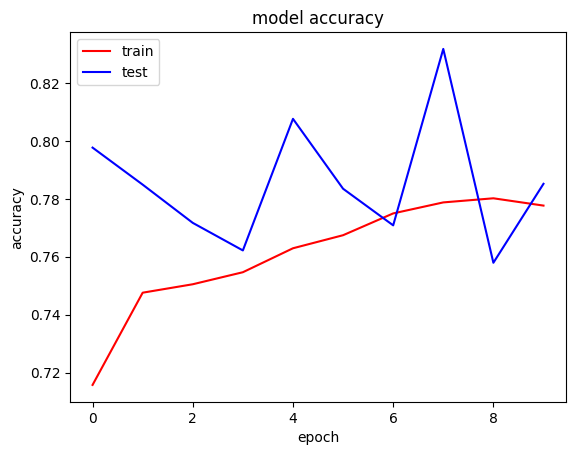

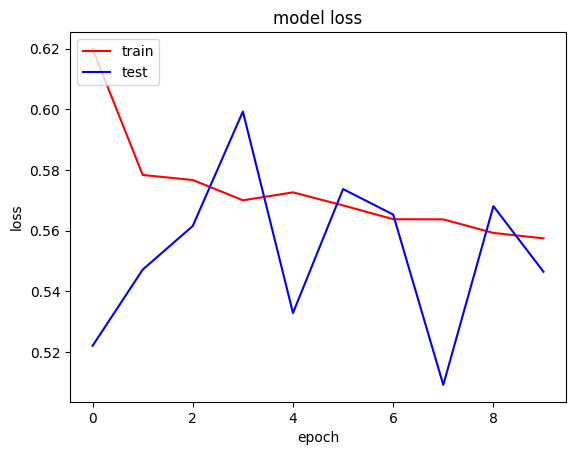

In [16]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:

class_weights[1] = 20
print(class_weights)

{0: 0.5661296546401697, 1: 20}


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


              precision    recall  f1-score   support

           0       0.95      0.82      0.88      8824
           1       0.32      0.64      0.43      1176

    accuracy                           0.80     10000
   macro avg       0.63      0.73      0.65     10000
weighted avg       0.87      0.80      0.82     10000

[[7197 1627]
 [ 418  758]]
79.55
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


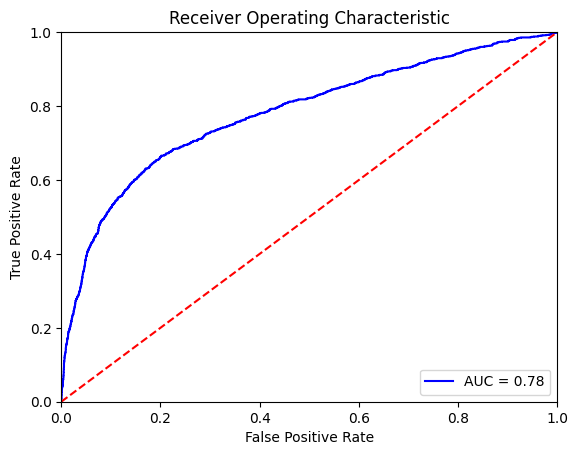

In [18]:
# Testing

y_pred = (model.predict(X_test) > 0.5).astype('int32')
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
preds = y_pred = model.predict(X_test) 
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Oversampling 

Another way of dealing with unbalanced data is to oversample the data. This means that the data will be balanced by creating additional samples from the minority class until equilibrium.

In [21]:
# Oversampling with SMOTE
from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train_orig)

y_resampled_orig = y_resampled
#y_resampled = to_categorical(y_resampled)




In [20]:
!pip install imblearn


  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1


In [22]:
# Train a Neural network on the training data. Use 20 percent of the training data as validation data.

# Initialize the neural network

## parameters of the NN
model = Sequential()
dropoutrate = 0.2
batchsize = 64
inputdim = X_train.shape[1]  #30 input features
adam = tf.keras.optimizers.Adam() # Adam optimizer
#sgd = tf.keras.optimizers.sgd(lr=0.001)


model.add(Dense(40, input_dim=inputdim, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(40, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(10, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropoutrate))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

# Training

history = model.fit(X_resampled, y_resampled, epochs=50,validation_split=0.2, batch_size=batchsize,verbose=1)

Epoch 1/50


/Users/pascal-maker/pascalworkspace/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 850us/step - accuracy: 0.7108 - loss: 0.5784 - val_accuracy: 0.5645 - val_loss: 0.7717
Epoch 2/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.7606 - loss: 0.5165 - val_accuracy: 0.6109 - val_loss: 0.6750
Epoch 3/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.7715 - loss: 0.4974 - val_accuracy: 0.5748 - val_loss: 0.7361
Epoch 4/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.7744 - loss: 0.4933 - val_accuracy: 0.6690 - val_loss: 0.5912
Epoch 5/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.7748 - loss: 0.4889 - val_accuracy: 0.6418 - val_loss: 0.6250
Epoch 6/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.7795 - loss: 0.4836 - val_accuracy: 0.6634 - val_loss: 0.6198
Epoch 7/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.7851 - loss: 0.4766 - val_accuracy: 0.6785 - val_loss: 0.5736
Epoch 8/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - accuracy: 0.7847 - loss: 0.4735 - val_accurac

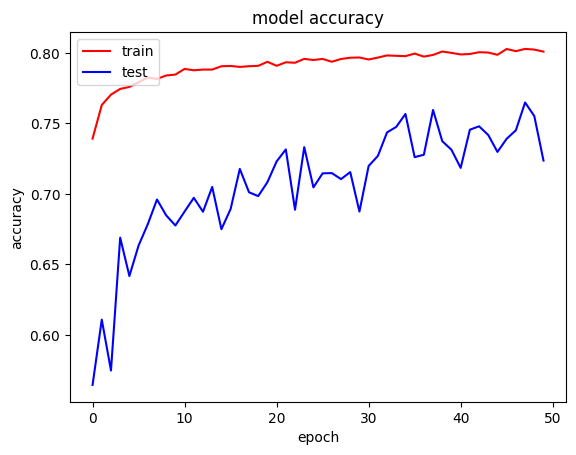

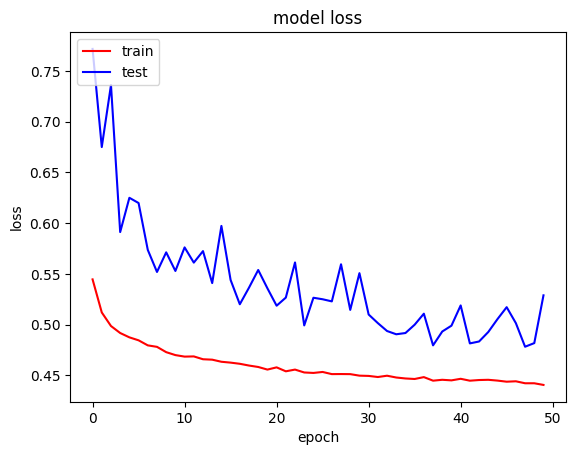

In [23]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


              precision    recall  f1-score   support

           0       0.93      0.90      0.91      8824
           1       0.39      0.50      0.44      1176

    accuracy                           0.85     10000
   macro avg       0.66      0.70      0.68     10000
weighted avg       0.87      0.85      0.86     10000

[[7916  908]
 [ 591  585]]
85.00999999999999
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


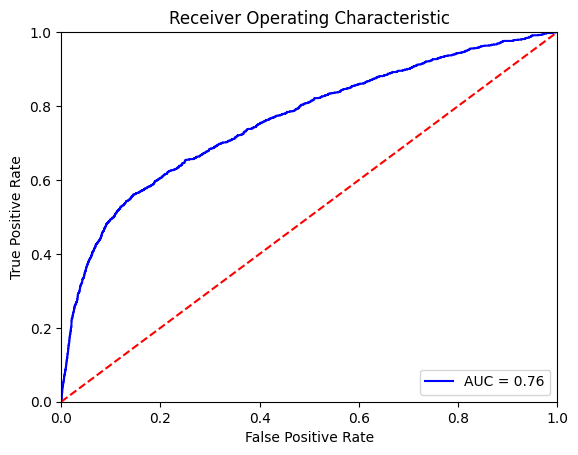

In [24]:
# Testing

y_pred = (model.predict(X_test) > 0.5).astype('int32')
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
preds = y_pred = model.predict(X_test) 
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

